# Data Preprocessing

In [16]:
# Import packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import helper
import importlib
_ = importlib.reload(helper)


Let's read the data into a [Pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html) so that we can begin to understand it.

*Note, we'll set `error_bad_lines=False` when reading the file in as there appear to be a very small number of records which would create a problem otherwise.*

In [17]:
dataset_name = 'ml-latest-small'
data_folder = f'data/{dataset_name}'


In [18]:
df_interactions = pd.read_csv(
    f'{data_folder}/ratings.csv',
    sep=',',
    encoding="ISO-8859-1",
    header=0,
#     error_bad_lines=False,
)
df_interactions.head()


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [19]:
df_interactions = df_interactions.rename(
    columns={
        'userId':'USER_ID',
        'movieId':'ITEM_ID',
        'rating':'RATING',
        'timestamp':'TIMESTAMP',
    }
)
df_interactions



,USER_ID,ITEM_ID,RATING,TIMESTAMP
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [20]:
helper.put_csv(df_interactions, dataset_name, "interactions.csv.gz")


In [21]:
df_users = pd.DataFrame(df_interactions['USER_ID'].unique(), columns=['USER_ID'])
df_users

,USER_ID
0,1
1,2
2,3
3,4
4,5
...,...
605,606
606,607
607,608
608,609


In [22]:
helper.put_csv(df_users, dataset_name, "users.csv.gz")


In [23]:
df_items = pd.read_csv(
    f'{data_folder}/movies.csv',
    sep=',',
    encoding="ISO-8859-1",
    header=0,
#     error_bad_lines=False,
)
df_items.head()


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [24]:
df_items = df_items.rename(
    columns={
        'movieId':'ITEM_ID',
    }
)
df_items


,ITEM_ID,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [25]:
helper.put_csv(df_items, dataset_name, "items.csv.gz")

  FutureWarning



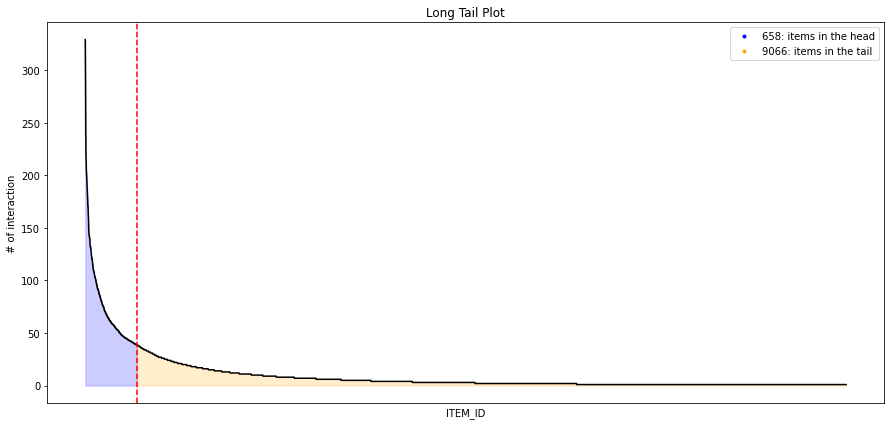

In [26]:
helper.draw_long_tail(df_interactions, "ITEM_ID")


In [27]:
quantiles = [0, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.98, 0.99, 1]
users = df_interactions['USER_ID'].value_counts()
items = df_interactions['ITEM_ID'].value_counts()


In [28]:
helper.draw_quantile(df_interactions, 'USER_ID', quantiles=quantiles)


alt.Chart(...)

In [29]:
df_qntl = helper.calculate_quantile(df_interactions, 'USER_ID', quantiles=quantiles)
df_qntl.T


%,0.00,0.01,0.02,0.05,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,0.95,0.98,0.99,1.00
Observation,20.0,20.0,20.0,22.0,24.0,32.0,40.0,54.0,70.5,101.4,140.0,216.0,400.3,610.75,976.64,1256.22,2698.0


As we can see, only about x% of users have rated y or more items.

In [30]:
helper.draw_quantile(df_interactions, 'ITEM_ID', quantiles=quantiles)


alt.Chart(...)

In [31]:
df_qntl = helper.calculate_quantile(df_interactions, 'ITEM_ID', quantiles=quantiles)
df_qntl.T


%,0.00,0.01,0.02,0.05,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,0.95,0.98,0.99,1.00
Observation,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,3.0,4.0,7.0,12.0,27.0,47.0,83.0,114.54,329.0


As we can see, only about u% of items have been rated by v users.

### Clean

Let's filter out this long tail.

In [32]:
users = users[users >= 20]
items = items[items >= 3]


In [33]:
df_interactions_reduced = df_interactions.merge(pd.DataFrame({'USER_ID': users.index})).merge(pd.DataFrame({'ITEM_ID': items.index}))
df_interactions_reduced


,USER_ID,ITEM_ID,RATING,TIMESTAMP
0,1,1,4.0,964982703
1,5,1,4.0,847434962
2,7,1,4.5,1106635946
3,15,1,2.5,1510577970
4,17,1,4.5,1305696483
...,...,...,...,...
94789,603,4424,4.0,1000194402
94790,606,4424,4.0,1173570229
94791,599,27722,3.5,1519116264
94792,606,27722,4.0,1180473187


  FutureWarning



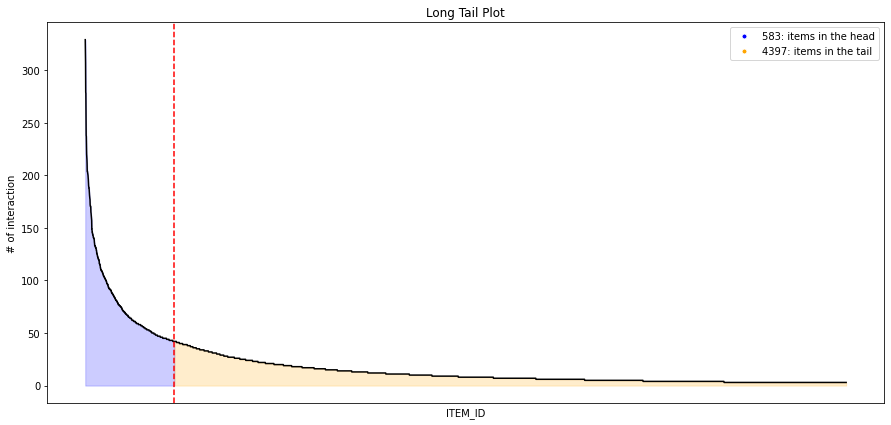

In [34]:
helper.draw_long_tail(df_interactions_reduced, "ITEM_ID")


Now, we'll recreate our customer and product lists since there are customers with more than 5 reviews, but all of their reviews are on products with less than 5 reviews (and vice versa).

In [35]:
helper.draw_quantile(df_interactions_reduced, 'USER_ID', quantiles=quantiles)


alt.Chart(...)

In [36]:
df_qntl = helper.calculate_quantile(df_interactions_reduced, 'USER_ID', quantiles=quantiles)
df_qntl.T


%,0.00,0.01,0.02,0.05,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,0.95,0.98,0.99,1.00
Observation,17.0,20.0,20.0,21.0,23.9,31.0,39.0,53.0,69.5,97.4,135.0,205.0,373.1,570.85,900.0,1113.43,2406.0


In [37]:
helper.draw_quantile(df_interactions_reduced, 'ITEM_ID', quantiles=quantiles)


alt.Chart(...)

In [38]:
df_qntl = helper.calculate_quantile(df_interactions_reduced, 'ITEM_ID', quantiles=quantiles)
df_qntl.T


%,0.00,0.01,0.02,0.05,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,0.95,0.98,0.99,1.00
Observation,3.0,3.0,3.0,3.0,3.0,4.0,5.0,6.0,8.0,11.0,17.0,26.0,46.0,71.0,112.0,143.21,329.0


In [39]:
helper.put_csv(df_interactions_reduced, dataset_name, "interactions_cleaned.csv.gz")

